# Taxa Selic e a inflação no Brasil
Para ver o artigo relacionado a este projeto, clique [AQUI](https://www.linkedin.com/in/tiagovivas/detail/recent-activity/posts/)

![politica_monetaria](/img/politica_monetaria.jpg)

## Inflação

A inflação é uma velha conhecida dos brasileiros há muitas décadas. Nos anos 90 era uma prática muito comum que, ao receber o salário no início do mês, as pessoas corressem aos mercados para fazer a compra do mês inteiro. A cada dia o preço dos produtos era maior que no dia anterior, em alguns casos podendo até dobrar de valor. Era a época da chamada **inflação galopante**.

O termo inflação indica o aumento nos preços de produtos e serviços ao longo do tempo. Apesar de hoje em dia a inflação não alcançar os mesmos níveis de antigamente, ela ainda existe e, na verdade, é um fenômeno natural em uma economia em desenvolvimento. Uma das formas de medir a inflação é através do Índice Nacional de Preços ao Consumidor Amplo - IPCA - medido pelo IBGE.

## Taxa Selic

Já o Selic é o Sistema Especial de Liquidação e de Custódia, parte integrante do Banco Central do Brasil que é responsável pelo registro e custódia das transações da maioria dos títulos emitidos pelo Tesouro Nacional. Periodicamente o Copom (Comitê de Política Monetária) se reúne para definir a meta da taxa Selic como uma das principais formas de controle da inflação no país.

## Papel da Selic na estabilidade financeira

Basicamente, quando a taxa Selic aumenta, fica mais caro para as pessoas e empresas tomarem crédito no mercado. Isso faz com que projetos de expansão sejam adiados e o consumo seja reduzido tornando mais interessante que os investidores imobilizem seu patrimônio em títulos de renda fixa e reduzindo a quantidade de dinheiro em circulação no mercado. Com menos consumo e mais formação de reservas, o preço dos produtos e serviços deixa de subir com tanta intensidade e causa uma redução na inflação medida.

O contrário também é válido, quando a taxa Selic é reduzida, torna-se mais fácil conseguir financiamentos baratos, as empresas tiram seus projetos do papel, os investidores precisam colocar seu patrimônio para trabalhar ativamente para conseguir rentabilidades interessantes. A economia fica mais aquecida, o consumo aumenta e consequentemente os preços dos produtos e serviços acompanha esse otimismo, causando um aumento da inflação.

Essa queda de braço entre Selic e IPCA cria **ciclos** no mercado financeiro do país. Esses ciclos são objeto de estudo neste documento, que analisará dados históricos e a relação de causalidade entre essas variáveis macroeconômicas.

# Obtenção dos dados

Os dados utilizados neste estudo foram obtidos através da API do Banco Central do Brasil, que pode ser conultada no seguinte endereço: [API_BCB](https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries). Os dados possuem um código que identifica a qual índice correspondem. Por exemplo, a série temporal da Selic-Meta e da inflação IPCA, que serão usadas no estudo, possuem os códigos 432 e 433, respectivamente.

In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

import cufflinks as cf

cf.go_offline()

In [2]:
# Definição da função responsável por obter as séries temporais.
# code_bcb: https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries
def search_bcb(code_bcb):
    url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(code_bcb)
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df.set_index('data', inplace=True)
    return df

In [3]:
selic = search_bcb(432) 
selic.columns = ["Selic_meta"]

ipca = search_bcb(433)
ipca.columns = ["IPCA"]

# Exploração dos dados

**Q1.** Quantas entradas existem em cada série temporal?

In [4]:
print("Na série temporal da Selic-meta temos {} entradas, de {} até {}".format(selic.shape[0], 
                                                                               selic.index[0].strftime('%d/%m/%Y'), 
                                                                               selic.index[-1].strftime('%d/%m/%Y')))
print("Na série temporal do IPCA temos {} entradas, de {} até {}".format(ipca.shape[0], 
                                                                               ipca.index[0].strftime('%d/%m/%Y'), 
                                                                               ipca.index[-1].strftime('%d/%m/%Y')))

Na série temporal da Selic-meta temos 8238 entradas, de 05/03/1999 até 22/09/2021
Na série temporal do IPCA temos 499 entradas, de 01/01/1980 até 01/07/2021


**Q2.** Quantos dados faltantes existem nas séries temporais?

In [5]:
print("Valores faltantes na Selic: {}%".format(selic.isnull().sum()[0]/selic.shape[0]))
print("Valores faltantes no IPCA: {}%".format(ipca.isnull().sum()[0]/ipca.shape[0]))

Valores faltantes na Selic: 0.0%
Valores faltantes no IPCA: 0.0%


**Q3.** Como é o comportamento das variáveis ao longo do tempo?

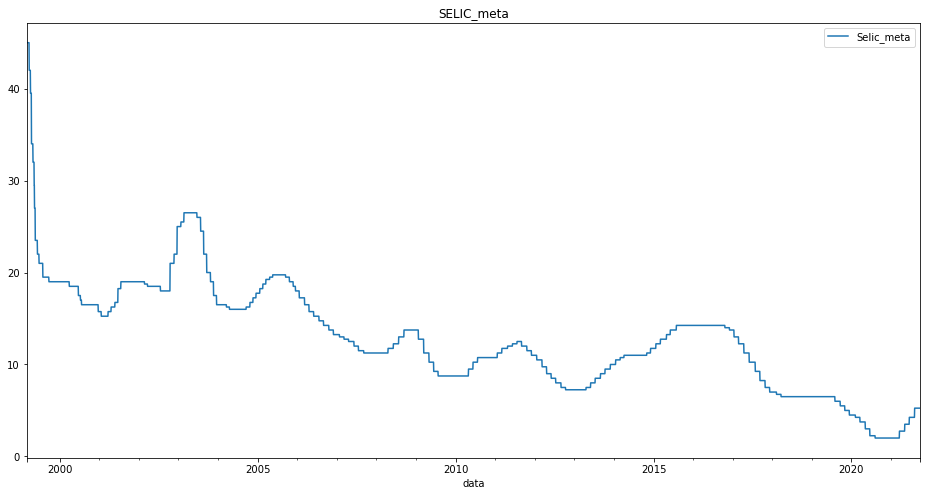

In [6]:
selic.plot(title="SELIC_meta", figsize=(16, 8));

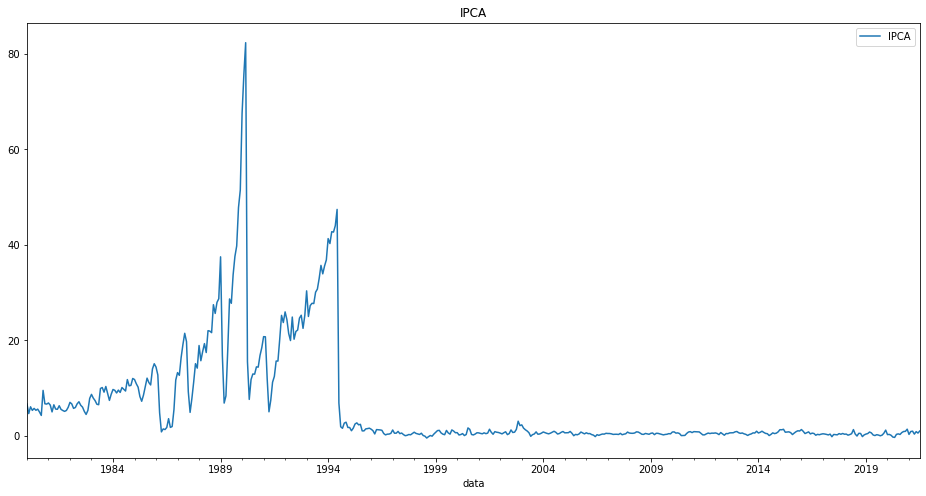

In [7]:
ipca.plot(title="IPCA", figsize=(16, 8));

Através da exploração inicial dos dados percebe-se:
* Não há dados faltantes nas séries;
* As datas de início das duas séries não coincide. A Selic começa em março de 1999 e o IPCA começa em janeiro de 1980;
* A periodicidade das duas séries também não coincide. A Selic possui dados diários enquanto o IPCA dados mensais;
* A série do IPCA possui uma descontinuidade, marcada pela introdução do Plano Real no Brasil.

# Preparação dos dados

Para realizar uma análise correta dos dados, é necessário visualizá-los em uma mesma data e que a periodicidade seja a mesma para ambos Selic e IPCA. Usaremos como data inicial 01/01/2000 e uma periodicidade mensal.

In [8]:
# Calculando valores acumulados dos últimos 12 meses para a inflação
ipca = ipca.assign(IPCA_acm=0)
for i in range(ipca.shape[0]):
    ret = 1
    for j in range(12):
        ret = ret * (1+ipca.iloc[i-j, 0]/100)
    ipca.iloc[i, 1] = round(100*(ret-1),2)
ipca.drop(columns=["IPCA"], inplace=True)

In [9]:
# Filtra apenas valores à partir do início do ano 2000
selic = selic[selic.index>="2000-01-01"]
ipca = ipca[ipca.index>="2000-01-01"]

In [10]:
# Construindo um DataFrame com Selic e IPCA nas mesmas datas
df = pd.DataFrame(ipca.IPCA_acm)
df = df.assign(Selic_meta=0.00)
for i in range(df.shape[0]):
    df.iloc[i, 1] = selic.iloc[selic.index == df.index[i]]

In [11]:
df.head(5)

,IPCA_acm,Selic_meta
data,,
2000-01-01,8.85,19.0
2000-02-01,7.86,19.0
2000-03-01,6.92,19.0
2000-04-01,6.77,18.5
2000-05-01,6.47,18.5


# Análise exploratória dos dados

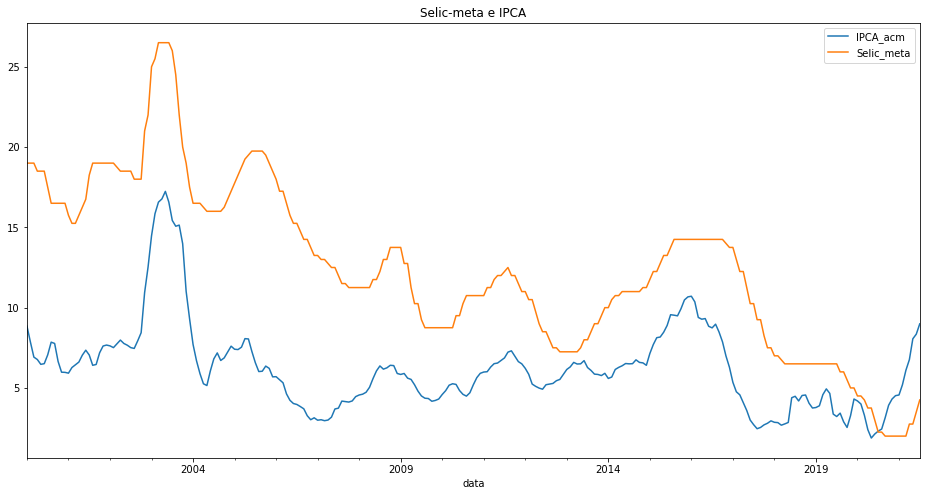

In [12]:
df.plot(title="Selic-meta e IPCA", figsize=(16, 8));

In [13]:
corr = 100*np.corrcoef(df.Selic_meta, df.IPCA_acm)[0][1]
print("A correlação entre Selic-meta e IPCA é de {}%".format(round(corr, 2)))

A correlação entre Selic-meta e IPCA é de 68.82%


Existe uma tendência de que as duas curvas andem juntas. Isso é comprovado matematicamente pelo cálculo da correlação. Vamos decompor as séries temporais em suas componentes de tendência para verificar se a correlação se confirma.

In [14]:
# Obtendo o componente de tendência na decomposição das séries temporais
decompose_ipca = seasonal_decompose(df.IPCA_acm)
trend_ipca = decompose_ipca.trend

decompose_selic = seasonal_decompose(df.Selic_meta)
trend_selic = decompose_selic.trend

In [15]:
# Construindo um DataFrame com os componentes de tendência
df_trend = pd.DataFrame(df.IPCA_acm)
df_trend = df_trend.assign(Trend_IPCA = trend_ipca.tolist())
df_trend = df_trend.assign(Trend_Selic = trend_selic.tolist())
df_trend.drop(columns=["IPCA_acm"], inplace=True)
df_trend.dropna(inplace=True)

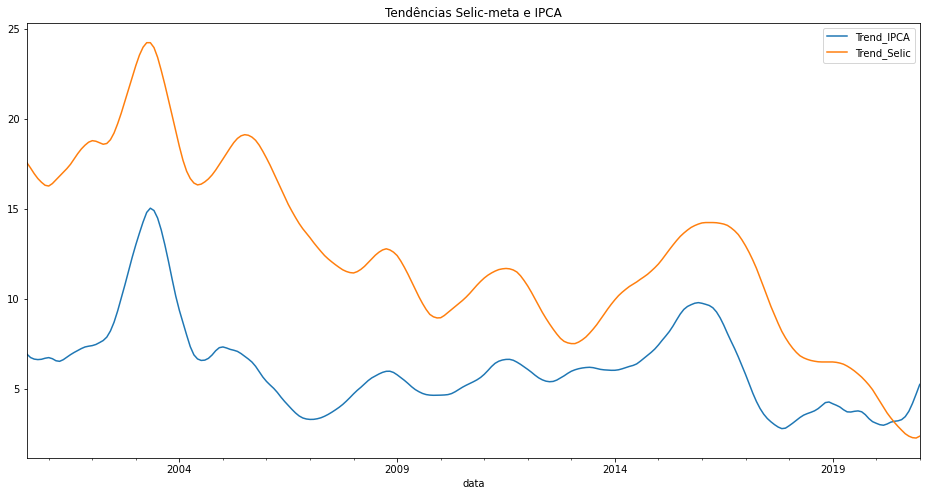

In [16]:
df_trend.plot(title="Tendências Selic-meta e IPCA", figsize=(16, 8));

In [17]:
corr = 100*np.corrcoef(df_trend.Trend_Selic, df_trend.Trend_IPCA)[0][1]
print("A correlação entre as tendências de Selic-meta e IPCA é de {}%".format(round(corr, 2)))

A correlação entre as tendências de Selic-meta e IPCA é de 74.71%


De fato, quando calculada sobre as curvas de tendência, a correlação entre a taxa Selic e o IPCA se torna ainda maior, confirmando que o movimento das duas variáveis está muito correlacionado.

Se observarmos os períodos de alta e de baixa, veremos que acontecem dentro da mesma janela de tempo nas duas variáveis. Na maior parte das vezes os topos e fundos do IPCA acontecem antes e são seguidos pelos topos e fundos da Selic alguns meses depois.

# Conclusão

A taxa Selic é uma importante ferramenta utilizada pelo Banco Central para realizar o controle inflacionário, fato comprovado pela forte correlação que existe entre a Selic e o IPCA. A taxa de inflação por sua vez é um ótimo indicador *leading* para a taxa Selic no curto prazo, sendo capaz de indicar com grande precisão o início e o fim de ciclos de alta na taxa básica de juros e, consequentemente, marca o ritmo dos ciclos em nossa economia.

Destaca-se ainda a situação atual que vivemos na data de escrita deste estudo. Pela primeira vez na série histórica analisada, o IPCA acumulado nos últimos 12 meses está acima da Selic-meta. Esse cenário gera taxas de juros reais negativas e indica um ciclo atípico de alta nas taxas de juros.